# About this Script

A Recurrant Neural Network is implemented with the Keras and TensorFlow Framework, in order to create a model which predicts whether a view is labeled as positive (0) or negative (1). The models accuracy and f1-score is then evaluated and the accuracy and loss graphs ploted.

##### Preparing Environment

In [1]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path
import time


# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras import backend as K
from keras.layers import Dropout
from sklearn.preprocessing import LabelEncoder
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer


# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers
from tensorflow.keras.layers import LSTM
from keras import metrics
from keras.utils.vis_utils import plot_model
from keras.layers.normalization import BatchNormalization


df = pd.read_csv('indeed_reviews_preprocessed_balanced.csv')
df = df.reindex(np.random.permutation(df.index)) 
df.head()

# Reduce data_set for training
# df = df[0:10000]
df.head()

,company,review,rating,sentiment
14502,university of leeds,Not a supportive workplace for BAME job candid...,3.0,1
18563,netsuite,I do get involved in many business and process...,3.0,1
9666,uchealth,I've worked here for over 3 years now. The ben...,3.0,1
16962,deloitte digital,One short sentence: No work/life balance! To ...,2.0,1
2358,banco do brasil,"Overall, work for Banco do Brasil is good for ...",4.0,0


##### Constants

In [2]:
NB_WORDS = 1000 #initialized later with length of unique words in dataset. Indicating no. of most frequent words we keep.
NB_START_EPOCHS = 25 # Number of epochs we start to train and plot accuracy and loss graphs
EPOCH_ITER = range(1,11) # For evaluating the metrics for number of 10 epochs
BATCH_SIZE = 32  # across a wide range of experiments the best results have been obtained with batch sizes m = 32 (Revisiting Small Batch Training for Deep Neural Networks, 2018)
MAX_LEN = 260  # Maximum number of words in a sequence (review)
REV_DIM = 256 # Number of dimensions of the indeed review word embeddings 256 rather common 300 hence power 2 computational power


'''
Definitions:

- Epoch = One Epoch is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE.
    - Small Epochs may lead to overfitting
    - Large Epochs may lead to underfitting

- Batch = Total number of training examples present in a single batch. You can’t pass the entire dataset into the neural net at once. So, you divide dataset into Number of Batches or sets or parts.
    - Small values give a learning process that converges quickly at the cost of noise in the training process.
    - Large values give a learning process that converges slowly with accurate estimates of the error gradient.
'''

'\nDefinitions:\n\n- Epoch = One Epoch is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE.\n    - Small Epochs may lead to overfitting\n    - Large Epochs may lead to underfitting\n\n- Batch = Total number of training examples present in a single batch. You can’t pass the entire dataset into the neural net at once. So, you divide dataset into Number of Batches or sets or parts.\n    - Small values give a learning process that converges quickly at the cost of noise in the training process.\n    - Large values give a learning process that converges slowly with accurate estimates of the error gradient.\n'

##### Helper Functions

In [3]:
# Helper Functions

# Compile and fit model
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='Adam'
                  , loss='binary_crossentropy' # using binary_crossentropy since output is based on two labels
                  , metrics=['acc',
                             'FalseNegatives',
                             'FalsePositives',
                             'TrueNegatives',
                             'TruePositives'
                            ])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)

    return history


# Plots the model training history for accuracy or loss (or any other metric_name)
def eval_metric(history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]
    
    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

# Test model for i epochs iterations
def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
            , y_train
            , epochs=epoch_stop
            , batch_size=BATCH_SIZE
            , verbose=0)
    results = model.evaluate(X_test, y_test)
    
    return results

# Removing common stopwords
def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 

# Lemmatizaton and Tokenization
def lem_and_tok(tokens):
    le = WordNetLemmatizer()
    lemmatized_tokens_empty = []
    for word in tokens:
        lemmatized_tokens = lemmatized_tokens_empty.append(le.lemmatize(word))
    tokenizated = [[w for w in sentence.split(" ") if w != ""] for sentence in tokens]
    return tokenizated

# returns text without special chars and punctuations
def cleanText(text): 
    cleaned = re.sub("[^a-zA-Z0-9']"," ",text)
    lowered = cleaned.lower()
    return lowered.strip()

###### Cleaning, Tokenization and initialize NB_WORDS

In [4]:
df.review = df.review.apply(remove_stopwords)

review_to_array = np.asarray(df["review"])
review_cleaned = [cleanText(t) for t in review_to_array]
# print(review_cleaned[0:2])

# Tokenization
cleaned_tokens = lem_and_tok(review_cleaned)

# Merge clean tokens
cleaned_tokens = [x for xs in cleaned_tokens for x in xs]

# Initialize NB_WORDS
cleaned_tokens_length = len(cleaned_tokens)
print("vocabularly size: " + str(cleaned_tokens_length))

# Test
# print(review_to_array[0])
cleaned_tokens[0:10]

vocabularly size: 578111


['not',
 'supportive',
 'workplace',
 'bame',
 'job',
 'candidates',
 'often',
 'undervalued',
 'underpaid',
 'not']

##### Train and Test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.review, 
                                                    df.sentiment, 
                                                    test_size=0.2, 
                                                    random_state=42)

print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
print("Value counts for Train sentiments")
print(y_train.value_counts())
print("Value counts for Test sentiments")
print(y_test.value_counts())
assert X_train.shape[0] == y_train.shape[0] #Immidiately raise error when sets are not even
assert X_test.shape[0] == y_test.shape[0] #Immidiately raise error when sets are not even

# Test
# print(X_train)

# Train data samples: 15395
# Test data samples: 3849
Value counts for Train sentiments
1    7720
0    7675
Name: sentiment, dtype: int64
Value counts for Test sentiments
0    1947
1    1902
Name: sentiment, dtype: int64


##### Converting Words to Vectors

In [6]:
tk = Tokenizer(num_words=NB_WORDS, 
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")

'''
Tokenizer Updates internal vocabulary based on a list of texts. 
This method creates the vocabulary index based on word frequency.
0 is reserved for padding. So lower integer means more frequent word
'''

tk.fit_on_texts(X_train)
word_index = tk.word_index # assigns unique number to word
# print(word_index)
X_train_seq = tk.texts_to_sequences(X_train) # word_index
X_test_seq = tk.texts_to_sequences(X_test)

In [7]:
# Creating word sequences of equal length
seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
seq_lengths.describe() # set MAX_LENGTH (the review with the most words) to 'max' to avoid information loss 
# print(seq_lengths)

# Padding
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)
# By that, no word truncating rather filling/padding reviews with 0, which don't fulfil max_length

# X_train_seq_trunc[1]  # Example of padded sequence

In [8]:
# Converting target class to categorical float numbers
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [9]:
# Splitting of validation set
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_oh, test_size=0.2, random_state=42)

assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

# print('Shape of validation set:',X_valid_emb.shape)
# print(X_train_emb.shape)
# print(X_valid_emb.shape)
# print(y_train_emb.shape)
# print(y_valid_emb.shape)

# Classifier (RNN)

##### About this Recurrent Neural Network

- Trained Embeddings based on own data suitable when just enough data for model (Qui et al., 2018). Further information about this model: Sequential API is used. Because it's most suitable for our problem. We neither have multiple inputs from different sources (only text data) nor have we multiple outputs (only two labels). 
<br>
<br>
- The first layer of our model is the Embedding Layer. There the feature vectors are generated. The Embedding layer has a size of input_dim x output_dim. Input_dim is the number of most instinct and common words in our case. The corpus has appr. 19000 words. So we want to keep half of those (8000), hence computational limits. The most common rule of thumb is 300 for the output_dim (e.g. Mikolow et al., 2013). However we seting size to 256 (2 to the power of 8) speeds up training time. Powers of 2 will increase cache utilization during data movement, thus reducing bottlenecks. We want to point out, that Patel & Bhattacharyya (2017) came up with a mathematical approach to calculate the best size for word embeddings ('lower bound'). The input length is equal to the MAX_LENGTH (in our case 260) of the sequence in order to avoid loss of information. 
<br>
<br>
- Next, we add the Long-Short-Term-Memory Layer (LSTM) Layer. This layer is very suitable for semantic parsing (Jia, Robin; Liang, Percy (2016). "Data Recombination for Neural Semantic Parsing". arXiv:1606.03622) and therefore also a good fit for our semantic-analyse. The rule of thumb for calculating the hidden nodes (number of neurons in the LSTM) is hidden_nodes := 2/3 * (timesteps * input_dim). In our case appr. 9000 hidden nodes would be needed (2/3 * 260 * 52). Because of computational reasons we only use half of the recommended hidden nodes (4500). Timesteps is the review with the most words (= max length of seq_lengths.describe() see code) which in our case is 260. For the hyperparameter input_dim, we choose 52. This equals all the lower and upper chars in the alphabet. If you have a higher number, the network gets more powerful. However, the number of parameters to learn also rises. This means it needs more time to train the network. Moreover, every LSTM layer should be accompanied by a Dropout layer. This layer will help to prevent overfitting by ignoring randomly selected neurons during training, and hence reduces the sensitivity to the specific weights of individual neurons. 20% is often used as a good compromise between retaining model accuracy and preventing overfitting. 
<br>
<br>
- Every LSTM layer should be accompanied by a Dropout layer. Dropout is a regularization technique for neural network models, against specialization proposed by Srivastava, et al., 2014. This layer will help to prevent overfitting by ignoring randomly selected neurons during training, and hence reduces the sensitivity to the specific weights of individual neurons. 20% is often used as a good compromise between retaining model accuracy and preventing overfitting. 
<br>
<br>
- The next layer is a BatchNormalization. Although there is a debate whether normalization is necessary, the authors of Batch Normalization say that it should be applied immediately before the non-linearity of the current layer (Hyv¨arinen & Oja, 2000). They say, that "it is likely to produce activations with a stable distribution.". Also Prof. Andrew Ng prefers to add the layer before nonlinearity (activation). 
<br>
<br>
- Lastly we add the Dense Layer, which is the most frequent layer. For the activation function we use softmax, because softmax assumes that each example is a member of exactly one class. This is suitable for our use case.
<br>
<br>
- For the model we used the binary crossentropy and Adam optimizer, as well as the sigmoid activation function, hence the binary classification problem type

In [10]:
# Specify Model
print("Let the training begin..")
start_time = time.time()

emb_model = models.Sequential()
embeddings = emb_model.add(layers.Embedding(NB_WORDS, REV_DIM, input_length=MAX_LEN, name='embeddings')) 
emb_model.add(LSTM(250, input_shape=(MAX_LEN,52))) # model.add(LSTM(hidden_nodes, input_shape=(timesteps, input_dim)))
emb_model.add(Dropout(0.20))

'''
To reduce overfitting, the dropout layer just randomly 
takes a portion of the possible network connections. 
This value is the percentage of the considered network 
connections per epoch/batch.
'''

emb_model.add(BatchNormalization())
emb_model.add(layers.Dense(2, activation='sigmoid'))

print("Training the Model took: " + "{}".format(time.time()-start_time) + " seconds" + "\n")

# Print Model Overview
emb_model.summary()
plot_model(emb_model)

Let the training begin..


NotImplementedError: Cannot convert a symbolic Tensor (module_wrapper/lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

**Note - to avoid NotimplementedError (if raised):**
<br>
"Cannot convert a symbolic Tensor (module_wrapper_8/lstm_8/strided_slice:0) 
to a numpy array. This error may indicate that you're trying to pass a Tensor 
to a NumPy call, which is not supported" --> downgrade numpy package (install numpy == 1.19.5)


# Evaluation

In [165]:
emb_history = deep_model(emb_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)
train_acc = emb_history.history['acc'][-1]
print("Trained model has an accuracy of " + str(train_acc))

Trained model has an accuracy of 0.9840624928474426


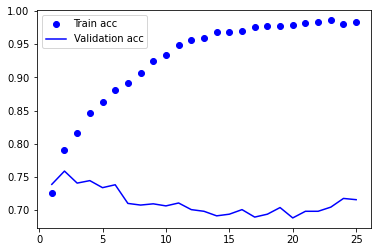

In [166]:
eval_metric(emb_history, 'acc')

**Interpretation:**
- Increasing training accuracy, but decreasing validation accuracy. The larger the gap, the higher is overfitting and specialization.

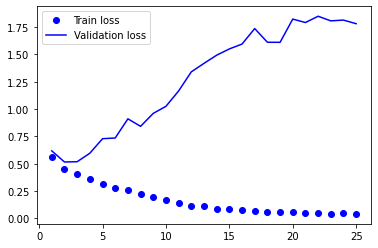

In [167]:
eval_metric(emb_history, 'loss')

**Interpretation:**
- The training loss keeps decreasing after every epoch. Our model is learning to recognize the specific reviews in the training set.
    
- The validation loss keeps increasing after every epoch. Our model is not generalizing well enough on the  validation set, however a drop is seen right at epoch 50. More epoch iterations may result in decrease in validation loss

- A good fit is identified by a training and validation loss that decreases to a point of stability with a           minimal gap between the two final loss values.

In [168]:
for i in EPOCH_ITER:   
    print('{} Epoch(s): '.format(EPOCH_ITER[i-1]) + '\n')
    emb_results = test_model(emb_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, EPOCH_ITER[i-1])
    print('\n')

    
'''
Methods for pruning the model:
- Reduce the learning rate to a very small number (e.g. 0.001 or even 0.0001).
- Provide more data.
- Set more dropout rates to a number like 0.2 & keep them uniform across the network (further see Srivastava, et al., 2014.)
- Try decreasing the batch size.
- Using appropriate optimizer: You may need to experiment a bit on this. Use different optimizers on the same network, and select an optimizer which gives you the least loss.
'''

1 Epoch(s): 

63/63 [==============================] - 10s 148ms/step - loss: 0.7979 - acc: 0.7245


2 Epoch(s): 

63/63 [==============================] - 8s 128ms/step - loss: 1.0651 - acc: 0.7190


3 Epoch(s): 

63/63 [==============================] - 10s 161ms/step - loss: 1.2180 - acc: 0.7175


4 Epoch(s): 

63/63 [==============================] - 8s 131ms/step - loss: 1.5451 - acc: 0.7135


5 Epoch(s): 



KeyboardInterrupt: 

**Interpretation:**
- Loss is increasing after 1 epoch (79,79%), accuracy is decreasing after 1 epoch (72,54%). One epoch should be used for initializing the model, hence avoiding specialization. (10000 reviews and 301355 words.)
<br>
<br>
- ...

# Save embeddings learned by model

In [ ]:
# save embeddings
embeddings = emb_model.get_layer('embeddings').get_weights()[0]
my_w2v = {}

for word, index in tk.word_index.items():
    my_w2v[word] = embeddings[index]

# print(w2v_my['company'])
first2pairs = {k: my_w2v[k] for k in list(my_w2v)[:2]}
# print(first2pairs)

my_w2v_df = pd.DataFrame(my_w2v)
# my_w2v_df.to_csv("own_trained_word_embeddings")
my_w2v_df.head()